# Transformer
## 1. 模型架构
![transformer架构](https://d2l.ai/_images/transformer.svg)


## 2. 辅助模块实现
### 2.1  Scaled Dot-Product Attention

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.module import T


class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, attn_dropout=0.1):
        """
        d_k: 缩放因子
        """
        super().__init__()
        self.d_k = d_k
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):
        """
        q: (batch_size, q_num, qk_dim)
        k: [batch_size, k_num, qk_dim]
        v: [batch_size, k_num, v_dim]
        """
        attn = q @ k.transpose(-2, -1)
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        # (batch_size,q_num,k_num)
        attn = self.dropout(F.softmax(attn, dim=-1))

        # (batch_size,q_num,v_dim)=(batch_size,q_num,k_num)@(batch_size,k_num,v_dim))
        output = attn @ v
        return output, attn


### 2.2 Multi-head Attention

In [4]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention
    """

    def __init__(self, n_head, d_model, d_k, d_v, attn_dropout=0.1):
        """

        """
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.w_out = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(d_k=self.d_k ** 0.5)

        self.dropout = nn.Dropout(attn_dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, q, k, v, mask=None):
        """
        q: (batch_size, q_num, d_model)
        k: (batch_size, k_num, d_model)
        v: (batch_size, v_num, d_model)
        """
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        batch_size, q_num, k_num, v_num = q.size(0), q.size(1), k.size(1), v.size(1)
        residual = q

        # B x L x H x D
        q = self.w_qs(q).view(batch_size, q_num, n_head, d_k)
        k = self.w_ks(k).view(batch_size, k_num, n_head, d_k)
        v = self.w_vs(v).view(batch_size, v_num, n_head, d_v)

        # 第一次维度变换：B x H x L x D
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)

        # q:B x H x L x D
        q, attn = self.attention(q, k, v, mask=mask)

        # 第二次维度变化： B x L x H x D -》 B x L x (H x D)
        q = q.transpose(1, 2).contiguous().view(batch_size, q_num, -1)
        q = self.dropout(self.w_out(q))

        # residual connection
        q += residual

        # Layer Normalization
        q = self.layer_norm(q)
        return q, attn

### 2.3 Positionwise Feed-Forward Networks

In [5]:
class PositionwiseFeedForward(nn.Module):
    """
    Position-wise feed forward: 增强非线性能力
    FFN(x)=ReLU(xW1+b)w2+b
    第一层将维度从 d_in扩展到 d_hid（通常为 4 倍），第二层压缩回 d_in，保持输入输出维度一致
    """

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid)
        self.w_2 = nn.Linear(d_hid, d_in)
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual
        x = self.layer_norm(x)
        return x


### 2.4 Position Encoder

In [8]:
import math


class PositionalEncoding(nn.Module):
    """Sinusoidal位置编码"""

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # [max_len, 1]
        position = torch.arange(max_len).unsqueeze(1)

        # 计算频率衰减项：10000^(-2i/d_model) = exp(-2i/d_model * ln(10000))
        # i的范围：0 ≤ i < d_model/2（对应偶数维度 2i 和奇数维度 2i+1）
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        # 初始化位置编码矩阵
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]

        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数维度：sin(pos * 10000^(-2i/d_model))
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数维度：cos(pos * 10000^(-2i/d_model))

        # 注册为缓冲区（不参与训练，仅存储）
        self.register_buffer('pe', pe.unsqueeze(0))  # [1, max_len, d_model]（广播维度）

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: 输入嵌入矩阵 [batch_size, seq_len, d_model]
        返回：添加位置编码后的嵌入矩阵 [batch_size, seq_len, d_model]
        """
        # 广播位置编码以匹配当前序列长度，并与输入嵌入相加
        x = x + self.pe[:, :x.size(1)]  # 广播机制自动适配批次和序列长度
        return self.dropout(x)

## 3. Encoder and Decoder
### 3.1 Encoder

In [14]:
class EncoderLayer(nn.Module):
    """
    Compose with two layers
    """

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        """
        d_model: 嵌入维度
        d_inner: （位置前馈网络）的隐藏层大小,通常为 d_model * 4
        n_head : 注意力头
        d_k : 每个注意力头key维度，通常为 d_model // n_head
        d_v: 同 d_k
        """
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head=n_head, d_model=d_model, d_k=d_k, d_v=d_v, attn_dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, self_attn_mask=None):
        enc_output, enc_slf_attn = self.slf_attn(enc_input, enc_input, enc_input, enc_mask=self_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        return enc_output, enc_slf_attn


class Encoder(nn.Module):
    def __init__(
            self,
            n_src_vocab: int,  # 词汇表大小（含特殊符号如<PAD>）
            d_word_vec: int,  # 词向量维度（Embedding Size）
            pad_idx: int,  # 填充符索引（用于掩码生成）
            n_layers: int,  # 编码器层数（默认6层）
            n_head: int,  # 多头注意力头数（需满足 d_model % n_head == 0）
            d_k: int,  # 键向量维度（每个头的维度）
            d_v: int,  # 值向量维度（每个头的维度）
            d_model: int,  # 模型隐藏层维度（与词向量维度一致）
            d_inner: int,  # 前馈网络中间层维度（通常为 d_model*4）
            dropout: float = 0.1,  # Dropout 概率（正则化参数）
            n_position: int = 200,  # 位置编码最大序列长度
            scale_emb: bool = False  # 是否对词向量进行缩放（默认False）
    ):
        super(Encoder, self).__init__()
        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=pad_idx)
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout, max_len=n_position)
        self.layer_stack = nn.ModuleList(
            [EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout) for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, src_seq, src_mask, return_attns=False):
        """
        :param src_seq:[batch_size, seq_len]
        :param src_mask: [batch_size, 1 ,seq_len]
        """
        enc_slf_attn_lst = []

        # [batch_size, seq_len, d_word_vec]
        enc_output = self.src_word_emb(src_seq)
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5

        enc_output = self.pos_encoder(enc_output)

        enc_output = self.layer_norm(enc_output)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(enc_output, src_mask=src_mask)
            enc_slf_attn_lst.append(enc_slf_attn)

        if return_attns:
            return enc_output, enc_slf_attn_lst
        # [batch_size, seq_len, d_model]
        return enc_output


## 3.2 Decoder

In [13]:
from typing import Optional, Tuple, List


class DecoderLayer(nn.Module):
    """
    Compose with three layers
    """

    def __init__(
            self,
            d_model: int,  # 模型隐藏层维度（与编码器一致，确保维度兼容）
            d_inner: int,  # 前馈网络中间层维度（通常为 d_model * 4）
            n_head: int,  # 多头注意力头数（需满足 d_model % n_head == 0）
            d_k: int,  # 键（Key）维度（每个注意力头的键向量长度）
            d_v: int,  # 值（Value）维度（每个注意力头的值向量长度）
            dropout: float = 0.1  # Dropout 概率（正则化参数，防止过拟合）
    ):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head=n_head, d_model=d_model, d_k=d_k, d_v=d_v, attn_dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head=n_head, d_model=d_model, d_k=d_k, d_v=d_v, attn_dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(
            self,
            dec_input: torch.Tensor,  # 解码器输入（词索引或嵌入后的向量）
            enc_output: torch.Tensor,  # 编码器输出（上下文表示）
            self_attn_mask: Optional[torch.Tensor] = None,  # 自注意力掩码（屏蔽填充/未来位置）
            dec_attn_mask: Optional[torch.Tensor] = None  # 编码器-解码器注意力掩码（屏蔽编码器填充）
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        返回：
            dec_output: 解码器输出（上下文感知的向量表示）
            dec_slf_attn: 自注意力权重列表（可选，用于分析）
            dec_attn_mask: 编码器-解码器注意力掩码（可选，用于调试）
        """
        dec_output, dec_slf_attn = self.slf_attn(dec_input, dec_input, dec_input, dec_mask=self_attn_mask)
        dec_output, dec_attn_mask = self.slf_attn(dec_output, enc_output, enc_output, enc_mask=dec_attn_mask)
        dec_output = self.pos_ffn(dec_output)
        return dec_output, dec_slf_attn, dec_attn_mask


class Decoder(nn.Module):

    def __init__(
            self,
            n_trg_vocab: int,  # 目标语言词汇表大小（含特殊符号如 <PAD>, <UNK> 等）
            d_word_vec: int,  # 目标语言词向量维度（词嵌入层输出维度）
            n_layers: int,  # 解码器层数（堆叠的 DecoderLayer 数量）
            n_head: int,  # 多头注意力头数（需满足 d_model % n_head == 0）
            d_k: int,  # 键（Key）维度（每个注意力头的键向量长度）
            d_v: int,  # 值（Value）维度（每个注意力头的值向量长度）
            d_model: int,  # 模型隐藏层维度（统一所有模块输入/输出维度）
            d_inner: int,  # 前馈网络中间层维度（通常为 d_model * 4）
            pad_idx: int,  # 目标序列填充符索引（用于生成掩码）
            n_position: int = 200,  # 位置编码最大序列长度（预生成位置编码矩阵的行数）
            dropout: float = 0.1,  # Dropout 概率（正则化参数，防止过拟合）
            scale_emb: bool = False  # 是否对词向量进行缩放（默认 False）
    ):
        super(Decoder).__init__()
        self.trg_word_emb = nn.Embedding(n_trg_vocab, d_word_vec, padding_idx=pad_idx)
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout, max_len=n_position)
        self.layer_stack = nn.ModuleList(
            [DecoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout) for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(
            self,
            trg_seq: torch.Tensor,  # 目标序列词索引（形状：[batch_size, trg_seq_len]）
            trg_mask: torch.Tensor,  # 目标序列掩码（形状：[batch_size, 1, trg_seq_len]）
            enc_output: torch.Tensor,  # 编码器输出（上下文表示，形状：[batch_size, src_seq_len, d_model]）
            src_mask: torch.Tensor,  # 源序列掩码（形状：[batch_size, 1, src_seq_len]）
            return_attns: bool = False  # 是否返回注意力权重列表（默认 False）
    ) -> Tuple[torch.Tensor, Optional[List[torch.Tensor]], Optional[List[torch.Tensor]]]:
        """
        返回：
            dec_output: 解码器输出（上下文感知的向量表示，形状：[batch_size, trg_seq_len, d_model]）
            dec_slf_attn_list: 自注意力权重列表（可选，每个元素形状：[batch_size, n_head, trg_seq_len, trg_seq_len]）
            dec_enc_attn_list: 交叉注意力权重列表（可选，每个元素形状：[batch_size, n_head, trg_seq_len, src_seq_len]）
        """
        dec_slf_attn_lst, dec_enc_attn_lst = [], []

        # [batch_size,trg_seql_len,d_word_vec]
        dec_output = self.trg_word_emb(trg_seq)
        if self.scale_emb:
            dec_output *= self.d_model ** 0.5
        dec_output = self.pos_encoder(dec_output)
        dec_output = self.layer_norm(dec_output)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn = dec_layer(
                dec_output,
                enc_output,
                dec_slf_attn_mask=trg_mask,
                dec_attn_mask=src_mask,
                trg_mask=trg_mask)
            dec_slf_attn_lst.append(dec_slf_attn)
            dec_enc_attn_lst.append(dec_enc_attn)
        if return_attns:
            return dec_output, dec_slf_attn_lst, dec_enc_attn_lst
        return dec_output


## 4.Transformer Model

In [16]:

def get_pad_mask(seq, pad_idx):
    """
    seq:[batch_size,seq_len]
    pad_idx:[batch_size,1]
    return:[batch_size,1,seq_len]

    seq = [[1, 2, 0], [3, 0, 0]]（batch_size=2, seq_len=3），pad_idx=0，
    seq != pad_idx → [[True, True, False], [True, False, False]]
    .unsqueeze(-2)；[batch_size, seq_len] 变为 [batch_size, 1, seq_len]。-> [[[True, True, False]], [[True, False, False]]]

    掩码与注意力分数的广播:[batch_size, num_heads, seq_len, seq_len]（num_heads是注意力头数）。掩码的形状为 [batch_size, 1, seq_len]，通过广播机制可扩展为 [batch_size, num_heads, seq_len, seq_len]
    """
    return (seq != pad_idx).unsqueeze(-2)


def get_subsequent_mask(seq):
    """
    屏蔽解码器自注意力中的未来位置信息，确保模型在生成当前 token 时仅依赖已生成的前序 token，避免信息泄露
    :seq: [batch_size, seq_len,]
    :return: [batch_size, seq_len, seq_len]
    """
    sz_b, len_s = seq.size()
    # [[[1, 1, 1]
    #  [1, 1, 1],
    #  [1, 1, 1]]]
    one_mat = torch.ones((1, len_s, len_s), device=seq.device)
    # 提取上三角并取反
    """
    [[[True, False, False],
      [True, True, False],
      [True, True, True]]]
    """
    subseq_mask = (1 - torch.triu(one_mat, diagonal=1)).bool()
    return subseq_mask


In [ ]:
class Transformer(nn.Module):
    def __init__(
            self,
            n_src_vocab: int,  # 源语言词汇表大小（含 <PAD>, <UNK> 等特殊符号）
            n_trg_vocab: int,  # 目标语言词汇表大小（含 <PAD>, <UNK> 等特殊符号）
            src_pad_idx: int,  # 源语言填充符索引（用于生成源序列掩码）
            trg_pad_idx: int,  # 目标语言填充符索引（用于生成目标序列掩码）
            d_word_vec: int = 512,  # 词嵌入维度（词向量长度，默认与 d_model 一致）
            d_model: int = 512,  # 模型隐藏层维度（所有模块输入/输出统一维度）
            d_inner: int = 2048,  # 前馈网络中间层维度（通常为 d_model * 4）
            n_layers: int = 6,  # 编码器/解码器层数（堆叠的 EncoderLayer/DecoderLayer 数量）
            n_head: int = 8,  # 多头注意力头数（需满足 d_model % n_head == 0）
            d_k: int = 64,  # 每个注意力头的键（Key）向量维度（d_model // n_head）
            d_v: int = 64,  # 每个注意力头的值（Value）向量维度（通常与 d_k 相同）
            dropout: float = 0.1,  # Dropout 概率（正则化，防止过拟合）
            n_position: int = 200,  # 位置编码最大序列长度（预生成位置编码矩阵的行数）
            trg_emb_prj_weight_sharing: bool = True,  # 是否共享目标词嵌入与输出投影层权重
            emb_src_trg_weight_sharing: bool = True,  # 是否共享源/目标词嵌入层权重
            scale_emb_or_prj: str = 'prj'  # 词嵌入/投影层缩放策略（'emb'|'prj'|'none'）
    ):
        super(Transformer, self).__init__()
        self.src_pad_idx, self.trg_pad_idx = src_pad_idx, trg_pad_idx
        assert d_model == d_word_vec, \
            'To facilitate the residual connections, \
             the dimensions of all module outputs shall be the same.'

        # Options here:
        #   'emb': multiply \sqrt{d_model} to embedding output
        #   'prj': multiply (\sqrt{d_model} ^ -1) to linear projection output
        #   'none': no multiplication

        assert scale_emb_or_prj in ['emb', 'trg', 'none']
        scale_emb = (scale_emb_or_prj == 'emb') if trg_emb_prj_weight_sharing else False
        self.scale_prj = (scale_emb_or_prj == 'prj') if trg_emb_prj_weight_sharing else False
        self.d_model = d_model

        self.encoder = Encoder(
            n_src_vocab=n_src_vocab,  # 源语言词汇表大小
            n_position=n_position,  # 位置编码最大长度
            d_word_vec=d_word_vec,  # 词嵌入维度
            d_model=d_model,  # 模型隐藏层维度
            d_inner=d_inner,  # 前馈网络中间层维度
            n_layers=n_layers,  # 编码器层数
            n_head=n_head,  # 多头注意力头数
            d_k=d_k,  # 键向量维度
            d_v=d_v,  # 值向量维度
            pad_idx=src_pad_idx,  # 源填充符索引
            dropout=dropout,  # Dropout 概率
            scale_emb=self.scale_emb  # 词嵌入缩放策略
        )

        self.decoder = Decoder(
            n_trg_vocab=n_trg_vocab,  # 目标语言词汇表大小
            n_position=n_position,  # 位置编码最大长度
            d_word_vec=d_word_vec,  # 词嵌入维度
            d_model=d_model,  # 模型隐藏层维度
            d_inner=d_inner,  # 前馈网络中间层维度
            n_layers=n_layers,  # 解码器层数
            n_head=n_head,  # 多头注意力头数
            d_k=d_k,  # 键向量维度
            d_v=d_v,  # 值向量维度
            pad_idx=trg_pad_idx,  # 目标填充符索引
            dropout=dropout,  # Dropout 概率
            scale_emb=self.scale_emb  # 词嵌入缩放策略
        )

        # 输出投影层（目标词预测）
        # [B,L,d_model] -> [B,L,n_trg_vocab]
        self.trg_word_prj = nn.Linear(d_model, n_trg_vocab, bias=False)

        # 参数初始化
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

        # 权重共享策略
        if trg_emb_prj_weight_sharing:
            # 共享目标词嵌入层和输出投影层间的权重，减少参数量
            self.trg_word_prj.weight = self.decoder.trg_word_emb.weight

        if emb_src_trg_weight_sharing:
            # 共享源语言与目标词嵌入层的权重（适用于同语言任务）
            self.encoder.src_word_emb.weight = self.decoder.trg_word_emb.weight

    def forward(
            self,
            src_seq: torch.Tensor,  # 源序列词索引（形状：[batch_size, src_seq_len]）
            trg_seq: torch.Tensor  # 目标序列词索引（形状：[batch_size, trg_seq_len]）
    ) -> torch.Tensor:
        """
         前向传播生成目标序列的预测 logits

         返回：
             seq_logit: 预测 logits（形状：[batch_size * trg_seq_len, n_trg_vocab]）
         """
        # [batch_size, 1, src_seq_len]
        src_mask = get_pad_mask(src_seq, self.src_pad_idx)

        # [batch_size,trg_seq_len,trg_seq_len] = [batch_size, 1, trg_seq_len] & [1, trg_seq_len, trg_seq_len]
        trg_mask = get_pad_mask(trg_seq, self.trg_pad_idx) & get_subsequent_mask(trg_seq)

        enc_output, *_ = self.encoder(src_seq, src_mask=src_mask)
        dec_output, *_ = self.decoder(trg_seq, trg_mask, enc_output, src_mask)

        # # 投影到目标词汇表：[batch_size, trg_seq_len, n_trg_vocab]
        seq_logit = self.trg_word_prj(dec_output)
        if self.scale_prj:
            seq_logit *= self.d_model ** -0.5

        # [batch_size * trg_seq_len , n_trg_vocab]
        return seq_logit.view(-1, seq_logit.size(-1))


## Transformer 学习率调度策略


Transformer 的学习率调度策略是其训练过程的核心组件之一，旨在通过动态调整学习率，平衡模型在训练初期的稳定性与后期的收敛精度。

---

### 5.1 为什么使用动态学习率

1. **解决训练初期的不稳定性**
   Transformer 模型参数通常随机初始化。若初始学习率过大，可能导致梯度爆炸或参数剧烈震荡。
   **解决方法**：采用 **学习率预热（Learning Rate Warmup）**，从较小值开始逐步提升学习率，使模型平稳进入优化轨道。

2. **平衡不同阶段的优化需求**
   - **预热阶段**：学习率从 0 逐渐上升，帮助模型适应参数空间的曲率，避免陷入不良局部极小。
   - **衰减阶段**：学习率按步数的平方根反比下降，减缓更新步长，提升收敛精度并抑制后期震荡与过拟合。

3. **适配模型规模**
   引入 **维度缩放因子** $d_{\text{model}}^{-0.5}$，使学习率与模型维度相关：
   - 大模型参数更多，梯度方差更大，需更小的基准学习率以保证稳定性。
   - 缩放后可实现不同规模模型间的训练一致性。

---

### 5.2 数学推导

Transformer 的学习率调度公式如下：

$$
\text{lr} = d_{\text{model}}^{-0.5} \cdot \min\left( \text{step}_{\text{num}}^{-0.5},\ \text{step}_{\text{num}} \cdot \text{warmup}_{\text{steps}}^{-1.5} \right)
$$

#### 公式分解

1. **模型维度缩放因子**：$d_{\text{model}}^{-0.5}$
   - **作用**：控制学习率的基准尺度，防止大模型因参数更新幅度过大而失稳。
   - **示例**：若 $d_{\text{model}} = 512$，则缩放因子为 $512^{-0.5} \approx 0.0442$。

2. **预热-衰减控制机制**
   公式中取两项的最小值：
   - 第一项：$\text{step}_{\text{num}}^{-0.5}$，表示学习率随训练步数增加而**按平方根反比衰减**。
   - 第二项：$\text{step}_{\text{num}} \cdot \text{warmup}_{\text{steps}}^{-1.5}$，表示学习率在预热阶段**线性增长**。

   当 $\text{step}_{\text{num}} = \text{warmup}_{\text{steps}}$ 时，两项相等：
   $$
   \text{step}_{\text{num}}^{-0.5} = \text{step}_{\text{num}} \cdot \text{warmup}_{\text{steps}}^{-1.5}
   \implies \text{warmup}_{\text{steps}}^{-0.5} = \text{warmup}_{\text{steps}} \cdot \text{warmup}_{\text{steps}}^{-1.5}
   \implies \text{成立}
   $$

---

#### 预热阶段（$\text{step}_{\text{num}} \leq \text{warmup}_{\text{steps}}$）

- **数学关系**：
  此阶段 $\text{step}_{\text{num}} \cdot \text{warmup}_{\text{steps}}^{-1.5} \leq \text{step}_{\text{num}}^{-0.5}$，因此 $\min(\cdot)$ 选择第二项。
  学习率表达式为：
  $$
  \text{lr} = d_{\text{model}}^{-0.5} \cdot \text{step}_{\text{num}} \cdot \text{warmup}_{\text{steps}}^{-1.5}
  $$
  即学习率随 $\text{step}_{\text{num}}$ **线性增长**。

- **示例**：设 $\text{warmup}_{\text{steps}} = 4000$，当 $\text{step}_{\text{num}} = 1000$ 时：
  - 第二项：$1000 \cdot 4000^{-1.5} \approx 0.0125$
  - 第一项：$1000^{-0.5} \approx 0.0316$
  - 取最小值得 $0.0125$，学习率处于上升期。

- **物理意义**：
  初始阶段模型尚未稳定，小学习率可避免梯度剧烈变化；逐步增加学习率有助于探索更优的参数区域。

---

#### 衰减阶段（$\text{step}_{\text{num}} > \text{warmup}_{\text{steps}}$）

- **数学关系**：
  此阶段 $\text{step}_{\text{num}}^{-0.5} < \text{step}_{\text{num}} \cdot \text{warmup}_{\text{steps}}^{-1.5}$，因此 $\min(\cdot)$ 选择第一项。
  学习率表达式为：
  $$
  \text{lr} = d_{\text{model}}^{-0.5} \cdot \text{step}_{\text{num}}^{-0.5}
  $$
  即学习率随 $\text{step}_{\text{num}}$ **按平方根反比衰减**。

- **示例**：仍设 $\text{warmup}_{\text{steps}} = 4000$，当 $\text{step}_{\text{num}} = 8000$ 时：
  - 第一项：$8000^{-0.5} \approx 0.0112$
  - 第二项：$8000 \cdot 4000^{-1.5} \approx 0.0177$
  - 取最小值得 $0.0112$，学习率进入下降阶段。

- **物理意义**：
  模型已接近收敛区域，减小学习率有助于精细调整参数，提高最终收敛质量。

---

### 5.3 实际应用建议

1. **预热步数选择**
   - 经验值：通常为总训练步数的 $10\%-15\%$。
   - 线性缩放规则：若批次大小翻倍，学习率可线性增加。

2. **模型维度适配**
   - 小模型（如 $d_{\text{model}} = 256$）：允许较高初始学习率，适合快速训练。
   - 大模型（如 $d_{\text{model}} = 768$）：需更小初始学习率，确保训练稳定性。

3. **可视化调试**
   - 绘制学习率曲线，观察预热阶段和衰减阶段的过渡是否平滑。
   - 使用不同颜色区分阶段（如绿色表示预热，红色表示衰减），便于分析模型行为。

---

### 总结

Transformer 的学习率调度策略通过动态调整学习率，解决了模型训练初期不稳定和后期收敛困难的问题。其核心思想是：
- **预热阶段**：线性增长学习率，帮助模型适应参数空间。
- **衰减阶段**：平方根反比衰减学习率，提升收敛精度。
- **维度缩放**：通过 $d_{\text{model}}^{-0.5}$ 适配不同规模模型。


## 5.3 代码实现

In [ ]:
from typing import Any
import numpy as np


class ScheduledOptim:
    """A wrapper class for learning rate scheduling with dynamic warmup.

    Args:
        optimizer (Any): 底层优化器实例（如 `torch.optim.Adam`），用于实际参数更新。
        lr_mul (float): 学习率乘数，用于调整基础学习率的缩放比例。
            典型值范围：`0.01`~`0.1`，需与 `d_model` 配合使用。
        d_model (int): 模型的隐藏层维度，决定学习率基准值。
            公式：`lr = lr_mul * d_model^{-0.5}`。
        n_warmup_steps (int): 预热步数（Warmup Steps），训练初期逐步增加学习率的阶段长度。
            建议设置为总训练步数的 5%~20%。
        n_steps (int, optional): 当前训练步数（内部维护），默认值为 0。
            通过 `step_and_update_lr()` 自动递增。

    Example:
        >>> optimizer = torch.optim.Adam(model.parameters(), lr=0)
        >>> scheduled_optim = ScheduledOptim(
        ...     optimizer=optimizer,
        ...     lr_mul=0.1,
        ...     d_model=768,
        ...     n_warmup_steps=10000
        ... )
    """

    def __init__(
            self,
            optimizer: Any,
            lr_mul: float,
            d_model: int,
            n_warmup_steps: int,
            n_steps: int = 0
    ):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = n_steps

    def step_and_update_lr(self) -> None:
        """Step with the inner optimizer and update learning rate dynamically."""
        self._update_lr_rate()
        self._optimizer.step()

    def zero_grad(self) -> None:
        """Zero out the gradients with the inner optimizer."""
        self._optimizer.zero_grad()

    def _get_lr_scale(self) -> float:
        """
        Caculate the learning rate scaling factor.

        Returns:
            float: learning rate scaling factor

        """
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_warmup_steps ** (-1.5))

    def _update_lr_rate(self) -> None:
        """
        Update the learning rate dynamically.
        """
        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()
        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

## 5.4 lr 可视化

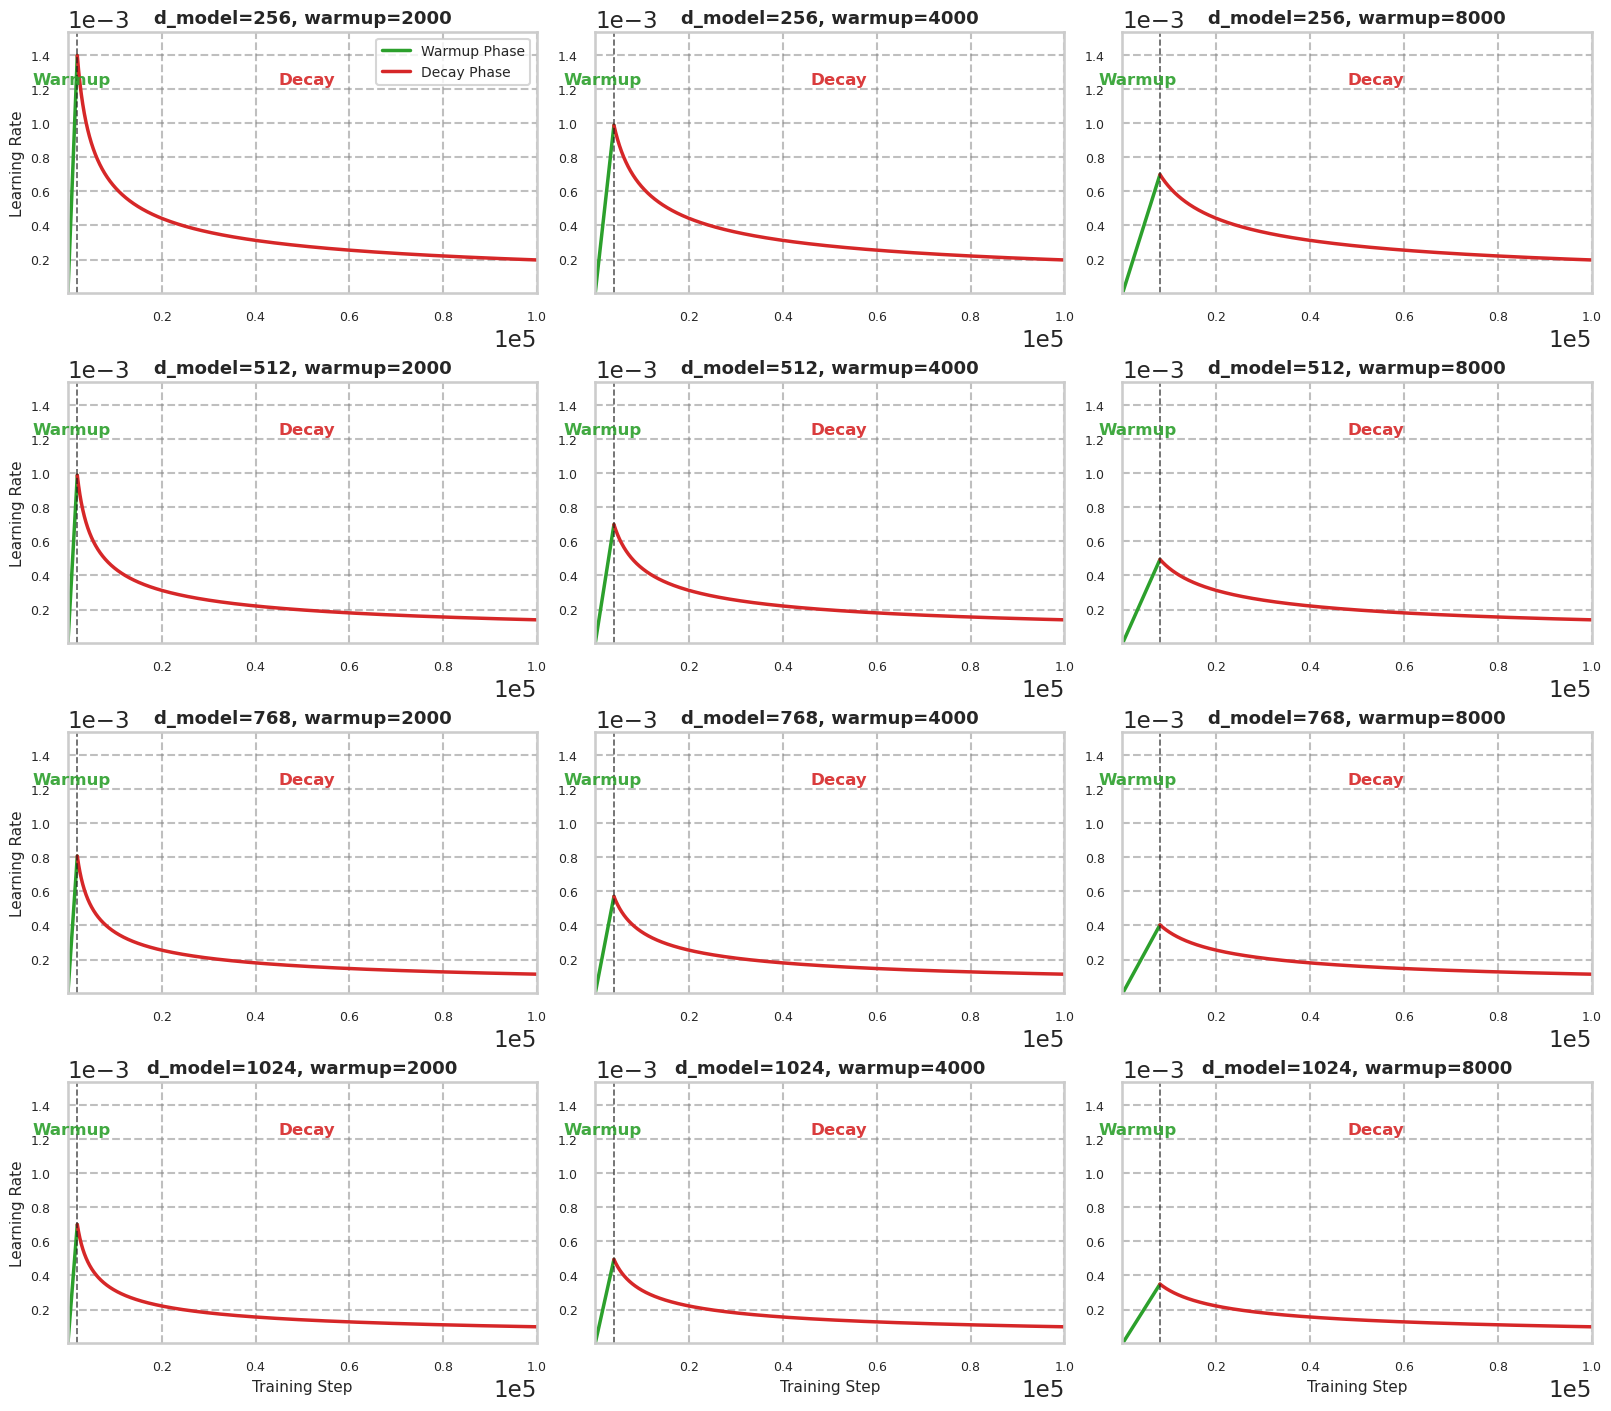

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# 参数设置
d_model_values = [256, 512, 768, 1024]
n_warmup_steps_values = [2000, 4000, 8000]
total_steps = 100000
lr_mul = 1.0

steps = np.arange(1, total_steps + 1)
lr_curves = {}

# 预计算所有学习率
for d_model in d_model_values:
    for n_warmup in n_warmup_steps_values:
        lr_curve = [
            lr_mul * (d_model ** -0.5) * min(s ** (-0.5), s * (n_warmup ** -1.5))
            for s in steps
        ]
        lr_curves[(d_model, n_warmup)] = np.array(lr_curve)

# 计算全局范围
max_lr = max(max(lr) for lr in lr_curves.values()) * 1.1

# 使用 constrained_layout 避免 tight_layout 警告
fig = plt.figure(figsize=(16, 14), constrained_layout=True)
grid = plt.GridSpec(len(d_model_values), len(n_warmup_steps_values), figure=fig)

# 颜色定义
WARMUP_COLOR = '#2ca02c'  # 绿色：预热阶段
DECAY_COLOR = '#d62728'  # 红色：衰减阶段
GRID_COLOR = 'gray'

for i, d_model in enumerate(d_model_values):
    for j, n_warmup in enumerate(n_warmup_steps_values):
        ax = fig.add_subplot(grid[i, j])
        lr = lr_curves[(d_model, n_warmup)]
        warmup_steps = n_warmup

        steps_warmup = steps[steps <= warmup_steps]
        lr_warmup = lr[steps <= warmup_steps]

        steps_decay = steps[steps > warmup_steps]
        lr_decay = lr[steps > warmup_steps]

        line1 = ax.plot(steps_warmup, lr_warmup, color=WARMUP_COLOR, linewidth=2.5, label='Warmup Phase')[0]
        line2 = ax.plot(steps_decay, lr_decay, color=DECAY_COLOR, linewidth=2.5, label='Decay Phase')[0]

        ax.set_title(f"d_model={d_model}, warmup={n_warmup}", fontdict={'fontsize': 13, 'fontweight': 'bold'})

        if j == 0:
            ax.set_ylabel("Learning Rate", fontsize=11)
        if i == len(d_model_values) - 1:
            ax.set_xlabel("Training Step", fontsize=11)

        ax.grid(True, linestyle='--', alpha=0.5, color=GRID_COLOR)
        ax.set_ylim(1e-6, max_lr)
        ax.set_xlim(1, total_steps)

        ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
        ax.tick_params(axis='both', which='major', labelsize=9)

        ax.axvline(x=warmup_steps, color='k', linestyle='--', linewidth=1.2, alpha=0.7)

        if i == 0 and j == 0:
            ax.legend(handles=[line1, line2], loc='upper right', fontsize=10, frameon=True, fancybox=True, shadow=False)

        ax.text(warmup_steps * 0.4, max_lr * 0.8, 'Warmup', color=WARMUP_COLOR, fontsize=12,
                fontweight='bold', alpha=0.9, ha='center')
        ax.text((warmup_steps + total_steps) * 0.5, max_lr * 0.8, 'Decay', color=DECAY_COLOR, fontsize=12,
                fontweight='bold', alpha=0.9, ha='center')

plt.show()

### 5.5 Transformer 学习率调度器分析

在本节中，我们将详细分析不同 `warmup_steps` 和 `d_model` 对学习率曲线的影响，并总结相应的规律。

#### 1. 横向分析：`warmup_steps` 的影响
- **warmup_steps 越大 → 分母越大 → 峰值越小**

- 学习率峰值公式

$$
\boxed{
  \text{lr}_{\text{peak}} =
  d_{\text{model}}^{-0.5} \cdot
  \text{warmup}_{\text{steps}}^{-0.5}
}
$$

👉 **结论**：峰值学习率 ∝ $1/\sqrt{\text{warmup}_{\text{steps}}}$

**数值例子**（以 $d_{\text{model}} = 512$ 为例）

| warmup_steps | 峰值学习率 ∝ $1/\sqrt{\text{warmup}_{\text{steps}}}$ |
|--------------|-----------------------------------------------------|
| 2000         | $1/\sqrt{2000} \approx 1/44.7 \approx 0.0224$     |
| 4000         | $1/\sqrt{4000} \approx 1/63.2 \approx 0.0158$     |
| 8000         | $1/\sqrt{8000} \approx 1/89.4 \approx 0.0112$     |
---

#### 2. 纵向分析：`d_model` 的影响

- 当 `d_model` 增大时，学习率的峰值会降低。

根据学习率公式中的 $d_{\text{model}}^{-0.5}$ 项，当 `d_model` 增大时，整个学习率曲线会被按比例缩小。这意味着较大的模型需要更平缓的学习率增长，以确保训练过程的稳定性。

---

#### 3. 衰减速度与 `step_num` 及 `d_model` 的关系

- **衰减速度主要与训练步数 (`step_num`) 相关，而与 `d_model` 关系不大**。

进入衰减阶段后（即 `step > warmup_steps`），学习率主要由 \( t^{-0.5} \) 决定，因此 `d_model` 对此阶段的学习率影响较小。

**公式解析**

进入衰减阶段后的学习率为：

$$
\text{lr}(t) = d_{\text{model}}^{-0.5} \cdot t^{-0.5}
$$

由于该阶段的学习率与 `d_model` 成反比但同时乘以一个常数因子，因此其变化趋势主要取决于 `t`，而非 `d_model`。

---

**总结**

通过以上分析，我们可以得出以下几点结论：

1. **`warmup_steps` 越大**，预热阶段结束时的学习率峰值越低。
2. **`d_model` 越大**，整体学习率曲线被压缩，峰值降低，适合更大规模模型的稳定训练。
3. **衰减速度主要受训练步数影响**，对于不同的 `d_model`，衰减速度基本一致。


## 6. 解码策略（Beam Search）

### 6.1 解码目标（序列联合概率最大化）
在预测阶段，Transformer 的输出为词库中每个位置单词的概率分布。将概率分布转化为最终翻译文本序列需要依赖解码策略，常见策略包括 `Greedy Search` 和 `Beam Search`。

![解码策略](img/3_1_translator.png)

无论采用何种策略，解码结果应满足：
**在给定输入文本 x 的条件下，输出的文本 y₁,y₂,...,yₙ 应使联合概率最大化**。

设 x 为待翻译文本，y₁,y₂,...,yₙ 为翻译结果序列，其联合概率公式为：
$$
P(y_1,y_2,\dots,y_n|x) = P(y_1|x) \cdot P(y_2|y_1,x) \cdot \dots \cdot P(y_n |y_1,y_2,\dots,y_{n-1},x)
$$

对数形式表示为：
$$
S(y_1,y_2,\dots,y_n|x) = \sum_{i=1}^{n} \log P(y_i|y_1,\dots,y_{i-1},x)
$$
其中 S 表示路径得分。由于概率 P ∈ (0,1)，对数得分 S 为负值，且序列越长绝对值越大。

---

### 6.2 Beam Search 原理
**Greedy Search 的局限性**：
逐位选择局部最优解可能导致全局次优结果。

**Beam Search 的改进**：
通过扩大搜索空间，维护当前最优的 k 个候选序列。关键参数为 Beam Size（束宽）k：
- k=1 时退化为 Greedy Search
- k>1 时保留更多候选路径，更接近全局最优
- k 增大会提升计算开销但增强搜索质量

**搜索流程示例**（Beam Size=2，词表大小=5，解码步长=3）：

![Beam Search 流程示意图](img/3_2_beam_search.png)

1. **Step 1**：从 A,B,C,D,E 中选择前 2 个高分词 A、C
2. **Step 2**：以 A、C 为起点扩展，计算 2×5=10 条候选路径，保留前 2 个高分路径 AB、CE
3. **Step 3**：继续扩展 AB、CE，保留 ABD、CED
4. **终止条件**：直到生成 `end` 标记或超过最大解码步长

最终从保留的 k 条完整序列中选择得分最高的作为输出。

---

### 6.3 长度惩罚机制
**问题背景**：
单纯最大化对数得分会导致偏好短文本（因 S 随长度增加而更负）

**解决方案**：引入长度惩罚项：
$$
S^* = \frac{S}{(len(y_1,\dots,y_n)+1)^\alpha}
$$
其中：
- $\alpha$ ∈ (0,1] 为惩罚系数（默认 $\alpha$=1）
- 分母随序列长度增长，降低长文本得分的负面影响
- 调整 $\alpha$ 的作用：
  - $\alpha$ > 1：增强对长文本的惩罚，使输出更短
  - $\alpha$ < 1：减弱对长文本的惩罚，使输出更长

**实际效果**：
通过平衡序列长度与得分，避免不合理短文本因得分更高而被误选。


### 6.4 Beam Search 的停止条件

![Beam Search Start](img/3_3_BeamSearchVisua1.png)

#### 6.4.1 解码到 `<end>` 标记停止
当候选序列生成 `<end>` 标记时，该序列立即终止后续解码。具体流程如下：

![标记终止](img/3_4_BeamSearchVisua2.png)

- **Step n-1**: [94,...,4,<end>] 完成解码，加入结果集
- **Step n**: 剩余 2 条序列继续解码
- **Step n+1**: 新生成的 2 条序列均含 `<end>`，全部加入结果集

此机制保证序列在语义完整时提前结束，其他未完成序列可继续扩展。

---

#### 6.4.2 早停机制（Early Stopping）
**触发条件**：
当前候选序列得分显著低于已完成的最优序列得分，通过以下公式判断：
$$
\text{当前得分} < \alpha \times \text{当前最优得分}
$$
- **α 的作用**：控制早停阈值（通常取 3），用于补偿长度惩罚导致的得分差异

![早停法](img/3_5_BeamSearchVisua3.png)

- **示例**（α=3）：
  - **Top 1**: 得分 -3.624（略低于最优 -3.1025），保留继续解码
  - **Top 2**: 得分 -13.7234（远低于最优），触发早停
  - **Top 3**: 得分 -15.3762（远低于最优），触发早停

**设计原理**：
由于当前得分尚未包含最终长度惩罚项，α 倍放宽阈值可避免误判长序列潜力。

---

### 6.5 时间复杂度分析

| 解码策略           | 时间复杂度       | 关键因素说明                          |
|--------------------|------------------|---------------------------------------|
| Greedy Search      | O(N × T)         | 每步仅保留最高分词，无需维护候选集合 |
| Beam Search        | O(K × N × T)     | 维护 K 条候选路径，每步遍历完整词表  |
| Exhaustive Search  | O(N² × T)        | 每步需计算所有可能路径的笛卡尔积    |

**公式推导**：
- **Greedy Search**：每步 1 次推理 + 1 次排序 → O(N × T)
- **Beam Search**：每步 K 次推理 + K×N 排序 → O(K × N × T)
- **Exhaustive Search**：每步 N 次扩展 → O(N² × T)

**效率对比**：
- **Greedy Search** 最快，但易陷入局部最优
- **Beam Search** 在精度与效率间取得平衡
- **Exhaustive Search** 理论上最优，但计算开销呈指数增长


## 6.6 代码实现

In [ ]:
PAD_WORD = '<blank>'  #填充符号
UNK_WORD = '<unk>'  #未知词
BOS_WORD = '<s>'  #起始符号
EOS_WORD = '</s>'  #结束符号

In [ ]:
class Translator(nn.Module):
    """
    基于预训练模型的翻译器（使用 Beam Search 解码策略）
    """

    def __init__(
            self,
            model: nn.Module,  # 预训练的编码器-解码器模型（如 Transformer）
            beam_size: int,  # 束搜索宽度（每一步保留的候选序列数量）
            max_seq_len: int,  # 生成序列的最大长度（防止无限循环）
            src_pad_idx: int,  # 源语言填充符 <pad> 的索引
            trg_pad_idx: int,  # 目标语言填充符 <pad> 的索引
            trg_bos_idx: int,  # 目标语言起始符 <bos> 的索引
            trg_eos_idx: int  # 目标语言结束符 <eos> 的索引
    ):
        super(Translator, self).__init__()

        # 超参数配置
        self.alpha = 0.7  # 长度惩罚系数（调节长文本得分）
        self.beam_size = beam_size
        self.max_seq_len = max_seq_len

        # 特殊符号索引
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.trg_bos_idx = trg_bos_idx
        self.trg_eos_idx = trg_eos_idx

        # 模型设置为评估模式
        self.model = model
        self.model.eval()

        # 注册初始化状态（PyTorch 缓冲区）
        # 初始序列模板：[[<bos>]]（形状：[1, 1]）
        self.register_buffer('init_seq', torch.LongTensor([[trg_bos_idx]]))

        # 空白序列模板（填充 <pad>，首位置为 <bos>，形状：[beam_size, max_seq_len]）
        self.register_buffer(
            'blank_seqs',
            torch.full((beam_size, max_seq_len), trg_pad_idx, dtype=torch.long)
        )
        self.blank_seqs[:, 0] = self.trg_bos_idx  # 设置起始符

        # 长度映射张量（用于计算实际长度，形状：[1, max_seq_len]）
        self.register_buffer(
            'len_map',
            torch.arange(1, max_seq_len + 1, dtype=torch.long).unsqueeze(0)
        )

    def _model_decode(self, trg_seq, enc_output, src_mask):
        """
        解码器前向传播，生成目标序列的词概率分布
        :param trg_seq: 目标序列输入 [beam_size, trg_seq_len]
        :param enc_output: 编码器输出 [beam_size, src_seq_len, hidden_dim]
        :param src_mask: 源序列掩码 [beam_size, src_seq_len]
        :return: 词概率分布 [beam_size, trg_seq_len, vocab_size]
        """
        # 生成目标序列的因果掩码（防止看到未来信息）
        trg_mask = get_subsequent_mask(trg_seq)
        dec_output, _ = self.model.decoder(trg_seq, trg_mask, enc_output, src_mask)
        return F.softmax(self.model.trg_word_prj(dec_output), dim=-1)

    def _get_init_state(self, src_seq, src_mask):
        """
        初始化 Beam Search 的候选序列与得分
        :param src_seq: 源序列输入 [batch_size, src_seq_len]
        :param src_mask: 源序列掩码 [batch_size, src_seq_len]
        :return: 编码器输出、初始得分、初始序列
        """
        beam_size = self.beam_size

        enc_output, _ = self.model.encoder(src_seq, src_mask)

        # 获取第一个时间步的解码结果（形状：[batch_size, 1, vocab_size]）
        dec_output = self._model_decode(src_seq, enc_output, src_mask)

        # 选择第一个时间步的概率分布（形状：[batch_size, vocab_size]）
        # 取 topk 个候选词作为初始序列:[batch_size,beam_size]
        best_k_probs, best_k_idx = dec_output[:, -1, :].topk(beam_size)

        # 计算初始得分（log 概率）:batch_size * beam_size == beam_size(batch_size=1)
        scores = torch.log(best_k_probs).view(beam_size)  # [beam_size]

        # 构建初始生成序列（形状：[beam_size, max_seq_len]）
        gen_seq = self.blank_seqs.clone().detach()
        gen_seq[:, 1] = best_k_idx[0]  # 替换第二个位置的 <pad>

        # 扩展编码器输出以匹配束宽（形状：[beam_size, src_seq_len, hidden_dim]）
        enc_output = enc_output.repeat(beam_size, 1, 1)

        return enc_output, gen_seq, scores

    def _get_the_best_score_and_idx(self, gen_seq, dec_output, scores, step):
        """
        计算当前步骤的最优候选序列与得分
        :param gen_seq: 当前生成序列 [beam_size, max_seq_len]
        :param dec_output: 解码器输出 [beam_size, step+1, vocab_size]
        :param scores: 当前得分 [beam_size]
        :param step: 当前解码步数
        :return: 更新后的生成序列与得分
        """
        beam_size = self.beam_size

        # 获取当前时间步的 topk 概率与索引（形状：[beam_size, beam_size]）
        best_k2_probs, best_k2_idx = dec_output[:, -1, :].topk(beam_size)

        # 计算 k^2 个候选序列的得分（形状：[beam_size, beam_size]）+ [beam_size,1]
        scores = torch.log(best_k2_probs) + scores.view(beam_size, 1)

        # 从 k^2 候选中选择 topk 个（形状：[beam_size]）
        best_scores, best_k_idx_in_k2 = scores.view(-1).topk(beam_size)

        # 计算行列索引（k^2 的二维展开）
        best_k_r_idxs, best_k_c_idxs = best_k_idx_in_k2 // beam_size, best_k_idx_in_k2 % beam_size

        # 获取最终的候选词索引
        best_k_idx = best_k2_idx[best_k_r_idxs, best_k_c_idxs]

        # 选择最优的历史路径k
        gen_seq[:, :step] = gen_seq[best_k_r_idxs, :step]
        # 添加最优的词汇
        gen_seq[:, step] = best_k_idx

        return gen_seq, best_scores

    def translate(self, src_seq):
        """
        Only accept batch size equals to 1 in this fucntion
        :param src_seq:[1,seq_len]
        """
        assert src_seq.size(0) == 1
        src_pad__idx, trg_eos_idx = self.src_pad_idx, self.trg_eos_idx
        max_seq_len, beam_size, alpha = self.max_seq_len, self.beam_size, self.alpha

        with torch.no_grad():
            src_mask = get_pad_mask(src_seq, src_pad__idx)
            # enc_output：[1, src_seq_len, hidden_dim]
            # gen_seq: [beam_size, max_seq_len]
            enc_output, gen_seq, scores = self._get_init_state(src_seq, src_mask)
            ans_idx = 0
            for step in range(2, max_seq_len):
                # src_seq[:,:step]:已生成序列作为输入预测下一个词
                # [batch_size, 1, vocab_size]
                dec_ouptut = self.__model_decode(src_seq[:, :step], enc_output, src_mask)
                gen_seq, scores = self._get_the_best_score_and_idx(gen_seq, dec_ouptut, scores, step)

                # check if all path finished
                # 标记结束符位置
                # [beam_size,max_seq_len]
                eos_locs = gen_seq == trg_eos_idx
                # 计算每个候选序列的实际长度（遇到第一个结束符的位置）
                seq_lens, _ = self.len_map.masked_fill(~eos_locs, max_seq_len).min(1)

                # 终止条件
                # eos_locs.sum(1) > 0表示该行有结束符，.sum(0)统计满足条件的行数
                if (eos_locs.sum(1) > 0).sum(0).item() == beam_size:
                    _, ans_idx = scores.div(seq_lens.float() ** alpha).max(0)
                    ans_idx += 1
                    break
                return gen_seq[ans_idx][:seq_lens[ans_idx]].tolist()


AttributeError: 'list' object has no attribute 'size'